In [1]:
def in_colab():
    from IPython.core import getipython
    return 'google.colab' in str(getipython.get_ipython())

in_colab()

True

In [2]:
if in_colab():
    !pip install mediapipe
    !pip install opencv-python
    !pip install pyshine
    !pip install plotly
    !pip install wget
else:
    %autosave 60
    %pip install --upgrade ipykernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [3]:
import os
import math
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pyshine as ps
from glob import glob
from copy import copy

Warning! PortAudio library not found
Warning! No module named 'keras.layers.convolutional'


In [4]:
if in_colab():
    from google.colab.patches import cv2_imshow
    from google.colab import drive
    drive.mount('/content/drive')

    !mkdir Resources
    !mkdir 'Resources/Video_เพื่อน'
    !mkdir 'Resources/Different camera angle'

    # Import file due to ram limitation
    %cp -r '/content/drive/MyDrive/Resources/Video_เพื่อน/landmarks' ./
    os.rename('landmarks', '/content/Resources/Video_เพื่อน/landmarks')
    %cp -r '/content/drive/MyDrive/Resources/Different camera angle/landmarks' ./
    os.rename('landmarks', '/content/Resources/Different camera angle/landmarks')
    %cp -r '/content/drive/MyDrive/Resources/weight_config_angle_list.csv' ./
    os.rename('/content/weight_config_angle_list.csv', '/content/Resources/weight_config_angle_list.csv')
    %cp -r '/content/drive/MyDrive/Resources/weight_config_cosine_list.csv' ./
    os.rename('/content/weight_config_cosine_list.csv', '/content/Resources/weight_config_cosine_list.csv')

Mounted at /content/drive


In [5]:
mp_pose = mp.solutions.pose

pose_video = mp_pose.Pose(static_image_mode=False,
                          min_detection_confidence=0.5, model_complexity=2)

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [6]:
if in_colab():
    resource = '/content/drive/MyDrive/Resources'
    friends_video = resource+'/Video_เพื่อน'
    diff_angle = resource+'/Different camera angle'
    slash = '/'
    desktop = '/content'
else:
    resource = f'C:\\Users\\{os.getlogin()}\Desktop\\resource'
    friends_video = f'C:\\Users\\{os.getlogin()}\\Desktop\\resource\\Video_เพื่อน'
    diff_angle = f'C:\\Users\\{os.getlogin()}\\Desktop\\resource\\Different camera angle'
    slash = '\\'
    desktop = f'C:\\Users\\{os.getlogin()}\Desktop'

# Landmark detection

In [7]:
def detectPose(frame: np.array):
    """
    Input:
        frame = numpy array of frame that is extracted by cv2

    Output:
        output_image = image that has skeleton in that frame
        norm_landmarks = camera coordinate every keypoint in that frame
        norm_world_landmarks = world coordinate every keypoint in that frame
    """

    output_image = frame.copy()
    output_image.flags.writeable = False
    result = pose_video.process(output_image)

    output_image.flags.writeable = True
    if result.pose_landmarks:
        norm_landmarks = result.pose_landmarks.landmark  # camera coordinate
        norm_world_landmarks = result.pose_world_landmarks.landmark  # world coordinate

        # เอา landmark ที่ไม่ได้ใช้ออก ใบหน้า นิ้วต่างๆ
        exclude_lndmk = list(range(11))
        exclude_lndmk.extend([29, 30, 17, 18, 21, 22])

        for i in exclude_lndmk:
            norm_landmarks[i].visibility = 0

        mp_drawing.draw_landmarks(image=output_image,
                                  landmark_list=result.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS,
                                  landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

    return output_image, norm_landmarks, norm_world_landmarks

In [8]:
def formatJoint(landmarks_obj: list):
    """
    Input:
        landmarks_obj = result landmarks that get from mediapipe

    Output:
        list of x,z,y coordinate for every keypoint eg. [[x1, y1, z1], [x2, y1, z1], ..., [x33, y33, z33]]
    """

    return list(map(lambda ladk: [ladk.x, ladk.y, ladk.z], landmarks_obj))

In [9]:
def landmark_detection(path_vid: str):
    """
    Input:
        path_vid = path of video

    Output:
        cam_ladk = numpy array that contain camera coordinate of all keypoint in every frame of the video
        world_ladk = numpy array that contain world coordinate of all keypoint in every frame of the video
        all_frame = list that contain all skeletal frame in the video
    """

    video = cv2.VideoCapture(path_vid)

    all_frame = []
    cam_ladk = []
    world_ladk = []
    count = 0

    while video.isOpened():

        ret, frame = video.read()

        if not ret:
            break

        # กรณีที่ mediapipe ไม่สามารถหา landmark ได้ detectPose จะเป็น Nonetype
        try:
            output_image, norm_landmarks, norm_world_landmarks = detectPose(
                frame)
        except:
            continue

        output_image = ps.putBText(output_image, "Frame: {}".format(count),
                                   text_offset_x=50, text_offset_y=50, vspace=10, hspace=10,
                                   font_scale=1, background_RGB=(0, 0, 0), text_RGB=(255, 250, 250))

        all_frame.append(output_image)
        cam_ladk.append(formatJoint(norm_landmarks))
        world_ladk.append(formatJoint(norm_world_landmarks))

        count += 1

    video.release()
    cv2.destroyAllWindows()
    return np.array(cam_ladk), np.array(world_ladk), all_frame

# Export files

In [10]:
def export_ladk(path_des: str):
    """
    Input:
        path_des = A path of folder that contains videos
    """
    ladk_dir = f"{desktop}{slash}landmarks_diff_angle"
    !rm -rf "{ladk_dir}
    !mkdir "{ladk_dir}"
    vid_list = glob(path_des+'/**/*.mp4')+glob(path_des+'/**/*.MOV')

    for vid in vid_list:
        movement_name = vid.split(slash)[-2]
        vid_name = vid.split(slash)[-1].replace('.mp4','').replace('.MOV','')

        if not os.path.isdir(f"{ladk_dir}/{movement_name}"):
            !mkdir "{ladk_dir}{slash}{movement_name}"

        !mkdir "{ladk_dir}{slash}{movement_name}{slash}{vid_name}"

        cam_ladk, world_ladk, all_frame = landmark_detection(vid)

        dir = f'{ladk_dir}{slash}{movement_name}{slash}{vid_name}'
        with open(f"{dir}{slash}cam_{vid_name}", "wb") as fp:
            np.save(fp, cam_ladk)
        with open(f"{dir}{slash}world_{vid_name}", "wb") as fp:
            np.save(fp, world_ladk)
        with open(f"{dir}{slash}all_frame_{vid_name}", "wb") as fp:
            pickle.dump(all_frame, fp)

    # if os.path.isdir("{}/landmarks".format(path_des)):
    #     !rm -rf "{path_des}/landmarks"

    # !rsync -a -q "/content/landmarks" "{path_des}"

# Import files

In [13]:
def import_file(path: str):
    """
    Input:
        path = path of video landmark

    Output:
        cam_ladk = numpy array that contain camera coordinate of all keypoint in every frame of the video
        world_ladk = numpy array that contain world coordinate of all keypoint in every frame of the video
        all_frame = list that contain all skeletal frame in the video
    """

    vid_name = path.split(slash)[-1]
    with open('{}{}cam_{}'.format(path, slash, vid_name), 'rb') as f:
        cam_ladk = np.load(f, allow_pickle=True)
    with open('{}{}world_{}'.format(path, slash, vid_name), 'rb') as f:
        world_ladk = np.load(f, allow_pickle=True)
    with open("{}{}all_frame_{}".format(path, slash, vid_name), "rb") as fp:
        all_frame = pickle.load(fp)

    return cam_ladk, world_ladk, all_frame

In [14]:
_,_,frame1 = import_file('/content/drive/MyDrive/Resources/Video_เพื่อน/landmarks/เตะเฉียงหน้า/เตะเฉียงหน้า')
_,_,frame2 = import_file('/content/drive/MyDrive/Resources/Video_เพื่อน/landmarks/เตะเฉียงหน้า/เตะเฉียงหน้า_6')

# Import weight

In [15]:
def gen_weight_csv(similarity_function):

    if "angle" in similarity_function.__name__.lower():

        cols = ['r_wrist', 'r_elbow', 'r_shoulder', 'r_hip', 'r_knee', 'r_ankle',
                'l_wrist', 'l_elbow', 'l_shoulder', 'l_hip', 'l_knee', 'l_ankle']

    elif "cosine" in similarity_function.__name__.lower():

        cols = ['R_findex_ankle', 'R_ankle_knee', 'R_knee_hip', 'R_hip_shoulder', 'R_index_wrist', 'R_wrist_elbow', 'R_elbow_shoulder',
                'L_findex_ankle', 'L_ankle_knee', 'L_knee_hip', 'L_hip_shoulder', 'L_index_wrist', 'L_wrist_elbow', 'L_elbow_shoulder',
                'lshoulder_rshoulder', 'lhip_rhip']
    weight_dict = dict.fromkeys(cols, 1)

    path = f'C:\\Users\\{os.getlogin()}\Desktop\\resource\\weight_config_{}.csv'

    if in_colab():
        path = 'weight_config_{}.csv'

    pd.DataFrame(weight_dict, index=[0]).to_csv(
        path.format(similarity_function.__name__.lower()))

In [16]:
def import_weight(weight_csv: str, vid_name: str):
    df = pd.read_csv(weight_csv, encoding='utf-8')
    return df[df['Name'] == vid_name].to_numpy()[0][1:]

# Comparison methods

## Mapping score function

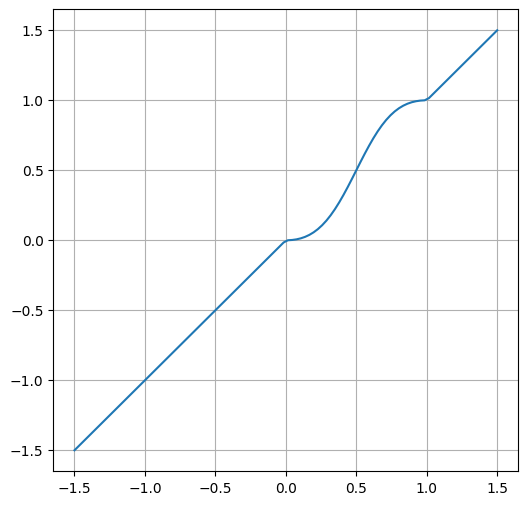

In [17]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1.5, 1.5, 100)
y = np.where((x >= 0) & (x <= 1), 1/(1+(x/(1-x))**-2), x)

plt.figure(figsize=(6, 6))
plt.plot(x, y)
plt.grid()
plt.show()

## Angle

### Extract function

In [18]:
def cal_norm_vec(point1: np.array, point2: np.array):

    vec = point2-point1
    vec_mag = np.linalg.norm(vec, axis=1)
    vec_norm = np.array(list(map((lambda x, y: x/y), vec, vec_mag)))

    return vec_norm

In [19]:
def cal_local_angle(point1: np.array, point2: np.array, point3: np.array):

    dot_result = np.sum(cal_norm_vec(point1, point2) *
                        cal_norm_vec(point3, point2), axis=1)
    angle = np.rad2deg(np.arccos(dot_result))

    return angle

In [20]:
def find_angle(world_ladk_vid: np.array):

    r_wrist = cal_local_angle(
        world_ladk_vid[:, 20], world_ladk_vid[:, 16], world_ladk_vid[:, 14])
    r_elbow = cal_local_angle(
        world_ladk_vid[:, 16], world_ladk_vid[:, 14], world_ladk_vid[:, 12])
    r_shoulder = cal_local_angle(
        world_ladk_vid[:, 14], world_ladk_vid[:, 12], world_ladk_vid[:, 24])
    r_hip = cal_local_angle(
        world_ladk_vid[:, 12], world_ladk_vid[:, 24], world_ladk_vid[:, 26])
    r_knee = cal_local_angle(
        world_ladk_vid[:, 24], world_ladk_vid[:, 26], world_ladk_vid[:, 28])
    r_ankle = cal_local_angle(
        world_ladk_vid[:, 26], world_ladk_vid[:, 28], world_ladk_vid[:, 32])

    l_wrist = cal_local_angle(
        world_ladk_vid[:, 19], world_ladk_vid[:, 15], world_ladk_vid[:, 13])
    l_elbow = cal_local_angle(
        world_ladk_vid[:, 15], world_ladk_vid[:, 13], world_ladk_vid[:, 11])
    l_shoulder = cal_local_angle(
        world_ladk_vid[:, 13], world_ladk_vid[:, 11], world_ladk_vid[:, 23])
    l_hip = cal_local_angle(
        world_ladk_vid[:, 11], world_ladk_vid[:, 23], world_ladk_vid[:, 25])
    l_knee = cal_local_angle(
        world_ladk_vid[:, 23], world_ladk_vid[:, 25], world_ladk_vid[:, 27])
    l_ankle = cal_local_angle(
        world_ladk_vid[:, 25], world_ladk_vid[:, 27], world_ladk_vid[:, 31])

    return np.array([r_wrist, r_elbow, r_shoulder, r_hip, r_knee, r_ankle,
                    l_wrist, l_elbow, l_shoulder, l_hip, l_knee, l_ankle]).T

### Similarity

In [21]:
def angle_similarity(ang1: np.array, ang2: np.array, weight: np.array, max_angle: int, expo: bool):
    """
    คำนวณความเหมือนกันของมุมในแต่ละข้อพับระหว่าง 2 วิดิโอ (0 - max_angle)

    input:
        ang1 : มุมข้อพับทั้ง 12 มุมของวิดิโอที่ 1 ได้จาก find_angle
        ang2 : มุมข้อพับทั้ง 12 มุมของวิดิโอที่ 2 ได้จาก find_angle
        weight : ค่าถ่วงน้ำหนัก ที่ได้จากฟังก์ชัน gen_weight
        max_angle : ค่าที่ใช้ในการ normalize แต่ละมุมข้อพับ

    output:
        numpy array ความเหมือนของมุมข้อพับ 12 มุมที่คูณกับค่าถ่วงน้ำหนักแล้ว มีช่วงตั้งแต่ 0 - 1
    """

    joint_diff_norm = (max_angle-np.abs(ang1 - ang2)) / max_angle

    if not expo:
        return joint_diff_norm * weight
    else:
        joint_diff_expo = np.where((joint_diff_norm >= 0) & (
            joint_diff_norm <= 1), 1/(1+(joint_diff_norm/(1-joint_diff_norm))**-2), joint_diff_norm)
        # each angle has range between 0 and 1 (default weight)
        return joint_diff_expo * weight

###Difference

In [22]:
def angle_difference(ang1: np.array, ang2: np.array, weight: np.array, max_angle: int, expo: bool):
    """
    คำนวณความต่างของมุมในแต่ละข้อพับระหว่าง 2 วิดิโอ (0 - max_angle)

    input:
        ang1 : มุมข้อพับทั้ง 12 มุมของวิดิโอที่ 1 ได้จาก find_angle
        ang2 : มุมข้อพับทั้ง 12 มุมของวิดิโอที่ 2 ได้จาก find_angle
        weight : ค่าถ่วงน้ำหนัก ที่ได้จากฟังก์ชัน gen_weight
        max_angle : ค่าที่ใช้ในการ normalize แต่ละมุมข้อพับ

    output:
        numpy array ความต่างของมุมข้อพับ 12 มุมที่คูณกับค่าถ่วงน้ำหนักแล้ว มีช่วงตั้งแต่ 0 - 1
    """

    joint_diff_norm = (np.abs(ang1 - ang2) / max_angle)

    if not expo:
        return joint_diff_norm * weight
    else:
        joint_diff_expo = np.where((joint_diff_norm >= 0) & (
            joint_diff_norm <= 1), 1/(1+(joint_diff_norm/(1-joint_diff_norm))**-2), joint_diff_norm)
        # each angle has range between 0 and 1 (default weight)
        return joint_diff_expo * weight

## Cosine

### Extract function

In [23]:
def find_limb(world_ladk_vid: np.array):
    """
    Output:
        result[limb][frame][coordinate]
    """

    R_findex_ankle = world_ladk_vid[:, 32] - world_ladk_vid[:, 28]
    R_ankle_knee = world_ladk_vid[:, 28] - world_ladk_vid[:, 26]
    R_knee_hip = world_ladk_vid[:, 26] - world_ladk_vid[:, 24]
    R_hip_shoulder = world_ladk_vid[:, 24] - world_ladk_vid[:, 12]
    R_index_wrist = world_ladk_vid[:, 20] - world_ladk_vid[:, 16]
    R_wrist_elbow = world_ladk_vid[:, 16] - world_ladk_vid[:, 14]
    R_elbow_shoulder = world_ladk_vid[:, 14] - world_ladk_vid[:, 12]

    L_findex_ankle = world_ladk_vid[:, 31] - world_ladk_vid[:, 27]
    L_ankle_knee = world_ladk_vid[:, 27] - world_ladk_vid[:, 25]
    L_knee_hip = world_ladk_vid[:, 25] - world_ladk_vid[:, 23]
    L_hip_shoulder = world_ladk_vid[:, 23] - world_ladk_vid[:, 11]
    L_index_wrist = world_ladk_vid[:, 19] - world_ladk_vid[:, 15]
    L_wrist_elbow = world_ladk_vid[:, 15] - world_ladk_vid[:, 13]
    L_elbow_shoulder = world_ladk_vid[:, 13] - world_ladk_vid[:, 11]

    lshoulder_rshoulder = world_ladk_vid[:, 11] - world_ladk_vid[:, 12]
    lhip_rhip = world_ladk_vid[:, 23] - world_ladk_vid[:, 24]

    return np.array([R_findex_ankle, R_ankle_knee, R_knee_hip, R_hip_shoulder, R_index_wrist, R_wrist_elbow, R_elbow_shoulder,
                     L_findex_ankle, L_ankle_knee, L_knee_hip, L_hip_shoulder, L_index_wrist, L_wrist_elbow, L_elbow_shoulder,
                     lshoulder_rshoulder, lhip_rhip]).transpose(1, 0, 2)

### Similarity

In [24]:
def cosine_similarity(vec1: np.array, vec2: np.array, weight: np.array, min_cosine_sim: int, expo: bool):
    """
    คำนวณความเหมือนด้วย cosine similarity (min_cosine_sim - 1)
    K(X, Y) = X dot Y / (||X||*||Y||)

    input:
        vec1: numpy array ที่ข้างในมีเวกเตอร์ท่อนแขนท่อนขา 16 ท่อนของวิดิโอที่ 1 ได้จากฟังก์ชัน find_limb
        vec2: numpy array ที่ข้างในมีเวกเตอร์ท่อนแขนท่อนขา 16 ท่อนของวิดิโอที่ 2 ได้จากฟังก์ชัน find_limb
        weight : ค่าถ่วงน้ำหนัก ที่ได้จากฟังก์ชัน gen_weight
        min_cosine_sim: ค่าที่ใช้การ normalize แต่ละท่อนแขนท่อนขา รับเข้ามาเป็นองศา

    output:
         numpy array ความเหมือนของเวกเตอร์ 16 ท่อนที่คูณกับค่าถ่วงน้ำหนักแล้ว มีช่วงตั้งแต่ 0 - 1
    """
    # 180 คือ -1, 90 คือ 0, 45 คือ sqrt(2)/2
    min_cosine_sim = np.cos(np.radians(min_cosine_sim))

    limb_diff_norm = (((np.sum(vec1*vec2, axis=1)/(np.linalg.norm(vec1, axis=1)
                      * np.linalg.norm(vec2, axis=1)))-min_cosine_sim)/(1-min_cosine_sim))

    if not expo:
        return limb_diff_norm * weight
    else:
        limb_diff_expo = np.where((limb_diff_norm >= 0) & (
            limb_diff_norm <= 1), 1/(1+(limb_diff_norm/(1-limb_diff_norm))**-2), limb_diff_norm)
        # each limb has range between 0 and 1 (default weight)
        return limb_diff_expo * weight

### Difference

In [25]:
def cosine_difference(vec1: np.array, vec2: np.array, weight: np.array, max_cosine_diff: int, expo: bool):
    """
    คำนวณความต่างด้วย 1 - cosine similarity (0 - max_cosine_diff)

    input:
        vec1: numpy array ที่ข้างในมีเวกเตอร์ท่อนแขนท่อนขา 16 ท่อนของวิดิโอที่ 1 ได้จากฟังก์ชัน find_limb
        vec2: numpy array ที่ข้างในมีเวกเตอร์ท่อนแขนท่อนขา 16 ท่อนของวิดิโอที่ 2 ได้จากฟังก์ชัน find_limb
        max_cosine_diff: ค่าที่ใช้การ normalize แต่ละท่อนแขนท่อนขา
        weight : ค่าถ่วงน้ำหนัก ที่ได้จากฟังก์ชัน gen_weight

    output:
        numpy array ความต่างของเวกเตอร์ 16 ท่อนที่คูณกับค่าถ่วงน้ำหนักแล้ว มีช่วงตั้งแต่ 0 - 1
    """

    # 180 คือ -1, 90 คือ 0, 45 คือ sqrt(2)/2
    max_cosine_diff = np.cos(np.radians(max_cosine_diff))

    limb_diff_norm = (1 - (np.sum(vec1*vec2, axis=1)/(np.linalg.norm(vec1,axis=1)*np.linalg.norm(vec2, axis=1))))/(1-max_cosine_diff)

    if not expo:
        return limb_diff_norm * weight
    else:
        limb_diff_expo = np.where((limb_diff_norm >= 0) & (
            limb_diff_norm <= 1), 1/(1+(limb_diff_norm/(1-limb_diff_norm))**-2), limb_diff_norm)
        # each limb has range between 0 and 1 (default weight)
        return limb_diff_expo * weight

# Automatic weight

In [26]:
def diff_move(extracted_ladk: np.array, windows: int, curr_frame: int, max_angle: int, method='aj'):

    if method.lower() == 'aj':
        if extracted_ladk.shape[1] == 12:
            adj_diff = angle_difference(ang1=extracted_ladk[curr_frame],
                                        ang2=extracted_ladk[curr_frame-1],
                                        weight=np.ones(12),
                                        max_angle=max_angle,
                                        expo=False)

        if extracted_ladk.shape[1] == 16:
            adj_diff = cosine_difference(vec1=extracted_ladk[curr_frame],
                                         vec2=extracted_ladk[curr_frame-1],
                                         weight=np.ones(16),
                                         max_cosine_diff=max_angle,
                                         expo=False)

        return adj_diff

    elif method.lower() == 'me':
        if extracted_ladk.shape[1] == 12:
            prev_diff = np.abs(
                extracted_ladk[curr_frame] - extracted_ladk[curr_frame-windows:curr_frame])/max_angle
            next_diff = np.abs(
                extracted_ladk[curr_frame] - extracted_ladk[curr_frame+1:curr_frame+windows+1])/max_angle

            total_diff = np.append(prev_diff, next_diff, axis=0)
            mean_total_diff = np.mean(total_diff, axis=0)

        if extracted_ladk.shape[1] == 16:
            max_cosine_diff = np.cos(np.radians(max_angle))
            prev_diff = (1 - (np.sum(extracted_ladk[curr_frame][np.newaxis, :] * extracted_ladk[curr_frame-windows:curr_frame], axis=2) / (np.linalg.norm(
                extracted_ladk[curr_frame][np.newaxis, :], axis=2) * np.linalg.norm(extracted_ladk[curr_frame-windows:curr_frame], axis=2))))/(1-max_cosine_diff)
            next_diff = (1 - (np.sum(extracted_ladk[curr_frame][np.newaxis, :] * extracted_ladk[curr_frame+1:curr_frame+windows+1], axis=2) / (np.linalg.norm(
                extracted_ladk[curr_frame][np.newaxis, :], axis=2) * np.linalg.norm(extracted_ladk[curr_frame+1:curr_frame+windows+1], axis=2))))/(1-max_cosine_diff)

            mean_total_diff_temp = np.stack((prev_diff.T, next_diff.T), axis=1)

            mean_total_diff = np.mean(
                np.mean(mean_total_diff_temp, axis=1), axis=1)

        return mean_total_diff+1

In [27]:
def MA_W(extracted_ladk: np.array, windows: int, max_angle=180, method='aj'):

    frame = extracted_ladk.shape[0]

    if (windows+windows) > frame:
        frame_diff = (windows+windows) - frame
        extracted_ladk = np.insert(
            extracted_ladk, 0, [extracted_ladk[0]]*(math.ceil(frame_diff/2)+1), axis=0)
        extracted_ladk = np.insert(
            extracted_ladk, -1, [extracted_ladk[-1]]*(math.ceil(frame_diff/2)+1), axis=0)
        frame = extracted_ladk.shape[0]

    # adjacent frame diff
    if method.lower() == 'aj':

        all_adj_diff = []
        for curr_frame in range(1, frame):
            all_adj_diff.append(diff_move(extracted_ladk=extracted_ladk,
                                          windows=windows,
                                          curr_frame=curr_frame,
                                          max_angle=max_angle,
                                          method=method.lower()))

        all_adj_diff.append(all_adj_diff[-1])
        all_adj_diff = np.array(all_adj_diff)

        # sliding window
        all_weight = []
        for curr_frame in range(windows, frame-windows+1):
            forward_dist = np.sum(
                all_adj_diff[curr_frame:curr_frame+windows+1], axis=0)
            backward_dist = np.sum(
                all_adj_diff[curr_frame-windows:curr_frame], axis=0)

            total_dist = (forward_dist+backward_dist)
            all_weight.append(total_dist)

        all_weight = np.array(all_weight)
        all_weight = (all_weight/(windows*2))+1

    # diff between f frame and frames in window
    elif method.lower() == 'me':

        # sliding window
        all_weight = []
        for curr_frame in range(windows, frame-windows+1):

            weight_by_frame = diff_move(extracted_ladk=extracted_ladk,
                                        windows=windows,
                                        curr_frame=curr_frame,
                                        max_angle=max_angle,
                                        method=method.lower())
            all_weight.append(weight_by_frame)

        all_weight = np.array(all_weight)

    # add first n frame to all_weight
    all_weight = np.insert(all_weight, 0, [all_weight[0]]*windows, axis=0)

    # add last n frame to all_weight
    all_weight = np.insert(all_weight, -1, [all_weight[-1]]*windows, axis=0)

    return all_weight

# DTW

In [28]:
def dm(extracted_ladk_vid1: np.array, extracted_ladk_vid2: np.array, sim_diff_function,
       weight, norm_value: int, windows: int, method='aj', expo=False):

    N = extracted_ladk_vid1.shape[0]
    M = extracted_ladk_vid2.shape[0]

    dist_mat = np.zeros((N, M))
    dist_ladk_mat = np.zeros((N, M), dtype=object)

    if isinstance(weight, str):
        if weight.lower() == 'auto':
            weight = MA_W(extracted_ladk_vid1, windows, norm_value, method)
    else:
        weight = [weight]*max(N, M)

    for i in range(N):
        for j in range(M):

            dist_ladk_mat[i, j] = sim_diff_function(
                extracted_ladk_vid1[i], extracted_ladk_vid2[j], weight[i], norm_value, expo)
            dist_mat[i, j] = np.sum(dist_ladk_mat[i, j]) / \
                np.sum(weight[i])  # 0-1 (Default weight)

    return dist_ladk_mat, dist_mat

In [29]:
def last_path(path_list, expert_frame):
    res_path = []
    for i,j in path_list:

        res_path.append((i,j))
        if i == expert_frame-1:
            break

    return res_path

In [30]:
def dp(dist_mat: np.array, mode: str):
    """
    ขวาล่าง-ซ้ายบน (cost)
    Find minimum-cost path through matrix `dist_mat` using dynamic programming.

    The cost of a path is defined as the sum of the matrix entries on that
    path. See the following for details of the algorithm:

    - http://en.wikipedia.org/wiki/Dynamic_time_warping
    - https://www.ee.columbia.edu/~dpwe/resources/matlab/dtw/dp.m

    The notation in the first reference was followed, while Dan Ellis's code
    (second reference) was used to check for correctness. Returns a list of
    path indices and the cost matrix.
    """

    N, M = dist_mat.shape

    # Initialize the cost matrix
    cost_mat = np.zeros((N, M))
    if 'difference' in mode:
        cost_mat = np.insert(cost_mat, 0, np.inf, axis=1)
        cost_mat = np.insert(cost_mat, 0, np.inf, axis=0)
    elif 'similarity' in mode:
        cost_mat = np.insert(cost_mat, 0, -np.inf, axis=1)
        cost_mat = np.insert(cost_mat, 0, -np.inf, axis=0)
    cost_mat[0, 0] = 0

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M), dtype='uint8')
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            if 'difference' in mode:
                i_penalty = np.argmin(penalty)
            elif 'similarity' in mode:
                i_penalty = np.argmax(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    vert_hor = 0

    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]

        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1

        elif tb_type == 1:
            # Insertion
            i = i - 1
            vert_hor += 1

        elif tb_type == 2:
            # Deletion
            j = j - 1
            vert_hor += 1

        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    cost_mat = cost_mat/len(path)
    path = last_path(path[::-1], N)

    return path, cost_mat, vert_hor

In [31]:
def unique_path(path):
    new_path = []
    temp_i = None
    temp_j = None
    for i, j in path:
        if (i == temp_i) or (j == temp_j):
            continue
        temp_i = i
        temp_j = j
        new_path.append((i, j))
    return np.array(new_path)

In [32]:
def dtw(name_vid1: str, name_vid2: str, extracted_ladk_vid1: np.array, extracted_ladk_vid2: np.array, sim_diff_function,
        path_finder, weight, norm_value=180, windows=50, thresh=False, MAW_method='aj', expo=False):

    thresh_name=''
    expo_name=''
    keyframe_name=''

    if 2 in set(weight):
        weight_name = '-Weight'
    else:
        weight_name = '-Unweight'

    if isinstance(weight, float):
        weight_name = '-MAW'
    else:
        window = ''

    if thresh:
        thresh_name = '-thresh'

    if expo:
        expo_name = '-expo'

    if MAW_method == 'me':
        maw_met_name = '-my-method'
    else:
        maw_met_name = ''

    dist_lndmk_mat, dist_mat = dm(extracted_ladk_vid1=extracted_ladk_vid1,
                                  extracted_ladk_vid2=extracted_ladk_vid2,
                                  sim_diff_function=sim_diff_function,
                                  weight=weight,
                                  norm_value=norm_value,
                                  windows=windows,
                                  method=MAW_method,
                                  expo=expo)

    path, cost_mat, vert_hor = path_finder(dist_mat=dist_mat,
                                           mode=sim_diff_function.__name__)

    row = np.array(path)[:, 0]
    col = np.array(path)[:, 1]

    dist_mat_path = dist_mat[row, col]

    unique_row = unique_path(path)[:, 0]
    unique_col = unique_path(path)[:, 1]
    dist_mat_unique = dist_mat[unique_row, unique_col]

    frames_count = dist_mat_unique.shape[0]

    if 'difference' in sim_diff_function.__name__:
        dist_mat_path = 1-dist_mat_path
        dist_mat_unique = 1-dist_mat_unique

    cost = np.sum(dist_mat_path)/len(path)
    std_all = np.std(dist_mat_path, dtype=np.float32)
    std_unique = np.std(dist_mat_unique, dtype=np.float32)
    mean = np.mean(dist_mat_path, dtype=np.float32)

    if thresh:
        thresh = np.mean(dist_mat_path)-0.03
        cost = np.sum(dist_mat_path[dist_mat_path > thresh])/len(path)

    # df1 = pd.DataFrame({'Unique_frames':list(zip(unique_row, unique_col)), 'Sim_score':list(dist_mat_unique)})
    # df1.to_csv("{}{}dtw_{}_{}_{}{}dtw_{}_{}_{}_{}{}{}{}{}{}{}.csv".format(desktop+slash+'dtw', slash, name_vid1, name_vid2, sim_diff_function.__name__,
    #                                                           slash, name_vid1, name_vid2, sim_diff_function.__name__, path_finder.__name__,
    #                                                          weight_name,window,maw_met_name,expo_name,thresh_name,keyframe_name))

    return None, None, path, dist_mat, dist_lndmk_mat, cost_mat, vert_hor, cost, [std_all, std_unique, mean, frames_count]

In [33]:
def dtw_2person(extracted_ladk_vid1: np.array, extracted_ladk_vid2: np.array, sim_diff_function,
        path_finder, weight, norm_value=180, windows=50, thresh=False, MAW_method='aj', expo=False):

    dist_lndmk_mat, dist_mat = dm(extracted_ladk_vid1=extracted_ladk_vid1,
                                  extracted_ladk_vid2=extracted_ladk_vid2,
                                  sim_diff_function=sim_diff_function,
                                  weight=weight,
                                  norm_value=norm_value,
                                  windows=windows,
                                  method=MAW_method,
                                  expo=expo)

    path, cost_mat, vert_hor = path_finder(dist_mat=dist_mat,
                                           mode=sim_diff_function.__name__)

    row = np.array(path)[:, 0]
    col = np.array(path)[:, 1]
    dist_mat_path = dist_mat[row, col]

    unique_row = unique_path(path)[:, 0]
    unique_col = unique_path(path)[:, 1]
    dist_mat_unique = dist_mat[unique_row, unique_col]

    frames_count = dist_mat_unique.shape[0]

    if 'difference' in sim_diff_function.__name__:
        dist_mat_path = 1-dist_mat_path
        dist_mat_unique = 1-dist_mat_unique

    cost = np.sum(dist_mat_path)/len(path)
    std_all = np.std(dist_mat_path, dtype=np.float32)
    std_unique = np.std(dist_mat_unique, dtype=np.float32)
    mean = np.mean(dist_mat_path, dtype=np.float32)

    if thresh:
        thresh = np.mean(dist_mat_path)-0.03
        cost = np.sum(dist_mat_path[dist_mat_path > thresh])/len(path)

    return cost

In [34]:
!mkdir "{desktop}{slash}dtw"

In [35]:
# keyframes_list, student_kf, path_test, dist_mat_test, dist_lndmk_mat_test, cost_mat_test, vert_hor_test, cost_test, stats = dtw('vid1','vid2',limb_vid1, limb_vid2, cosine_similarity, dp, 'auto', 90, 60, True, 'aj')

In [36]:
# keyframes_list, student_kf, path_test, dist_mat_test, dist_lndmk_mat_test, cost_mat_test, vert_hor_test, cost_test, stats = dtw('vid1', 'vid2', limb_vid1, limb_vid2, cosine_difference, dp, 'auto', 90, 60, False, 'aj')

# Find keyframes

In [37]:
def video_to_img(path):
    vid = cv2.VideoCapture(path)
    vid_name = path.split(slash)[-1].replace('.mp4','')
    !mkdir "{desktop}{slash}img{slash}{vid_name}"
    count = 0
    while vid.isOpened():

        ret, frame = vid.read()

        if not ret:
            break

        cv2.imwrite("{}{}img{}{}{}{}_{}.jpg".format(desktop, slash, slash, vid_name, slash, vid_name,count), frame)

        count += 1

    vid.release()
    cv2.destroyAllWindows()

## Find matching keyframe

In [46]:
def match_kf(keyframe_list, dist_mat):

    keyframe_copy = copy(keyframe_list)
    student_kf = []
    kf_score = []
    penalty = np.arange(0,0.3,0.1)

    for p in penalty:
        student_kf_temp = [0]
        kf_score_temp = []

        # เริ่มต้น
        low_bound = np.max(dist_mat[keyframe_copy[0], 0:])-p
        match_idx = np.where(dist_mat[keyframe_copy[0], 0:] >= low_bound)[0] #ครั้งแรกจะมีแค่ max อันเดียว, มากกว่า max ไม่มี
        min_match_idx = np.where(dist_mat[keyframe_copy[0], 0:] == np.sort(dist_mat[keyframe_copy[0], match_idx])[0])[0][0]

        print('kf: ',keyframe_copy[0])
        print('student_kf_temp: ',student_kf_temp)
        print('low bound: ',low_bound)
        print('match_idx: ',match_idx)
        print('min_match_idx: ',min_match_idx)
        print(np.sort(dist_mat[keyframe_copy[0], match_idx]))
        print('---------')

        student_kf_temp.append(min_match_idx)
        kf_score_temp.append(dist_mat[keyframe_copy[0], min_match_idx])

        for idx, kf in enumerate(keyframe_copy[1:]):
            idx = idx+1
            if keyframe_copy[-1] != kf:
                # ไส้กลาง
                low_bound = np.max(dist_mat[kf, student_kf_temp[idx]:])-p
                match_idx = student_kf_temp[idx]+np.where(dist_mat[kf, student_kf_temp[idx]:] >= low_bound)[0]
                min_match_idx = student_kf_temp[idx]+np.where(dist_mat[kf, student_kf_temp[idx]:] == np.sort(dist_mat[kf, match_idx])[0])[0][0]

                print('kf: ',kf)
                print('student_kf_temp: ',student_kf_temp)
                print('low bound: ',low_bound)
                print('match_idx: ',match_idx)
                print('min_match_idx: ',min_match_idx)
                print(np.sort(dist_mat[kf, match_idx]))
                print('---------')

                student_kf_temp.append(min_match_idx)
                kf_score_temp.append(dist_mat[kf, min_match_idx])

            else:
                # ตอนสุดท้าย

                low_bound = np.max(dist_mat[kf, student_kf_temp[idx]:])
                match_idx = student_kf_temp[idx]+np.where(dist_mat[kf, student_kf_temp[idx]:] >= low_bound)[0]
                min_match_idx = student_kf_temp[idx]+np.where(dist_mat[kf, student_kf_temp[idx]:] == np.sort(dist_mat[kf, match_idx])[-1])[0][0]

                print('kf: ',kf)
                print('student_kf_temp: ',student_kf_temp)
                print('low bound: ',low_bound)
                print('match_idx: ',match_idx)
                print('min_match_idx: ',min_match_idx)
                print(np.sort(dist_mat[kf, match_idx]))
                print('---------')

                student_kf_temp.append(min_match_idx)
                kf_score_temp.append(dist_mat[kf, min_match_idx])

        kf_score.append(np.mean(kf_score_temp))
        student_kf.append(student_kf_temp)

    keyframe_copy.insert(0,0)
    result =  student_kf[np.argmax(kf_score)]
    if dist_mat.shape[0]-1 not in keyframe_copy:
        keyframe_copy.append(dist_mat.shape[0]-1)
        result.append(dist_mat.shape[1]-1)


    if len(student_kf[np.argmax(kf_score)]) != len(keyframe_copy):
        print(keyframe_copy)
        print(student_kf[np.argmax(kf_score)])

    return keyframe_copy, result

In [48]:
def match_kf(keyframe_list, dist_mat):

    keyframe_copy = copy(keyframe_list)
    student_kf = []
    kf_score = []
    penalty = np.arange(0,0.3,0.1)

    for p in penalty:
        student_kf_temp = [0]
        kf_score_temp = []

        # เริ่มต้น
        low_bound = np.max(dist_mat[keyframe_copy[0], 0:])-p
        match_idx = np.where(dist_mat[keyframe_copy[0], 0:] >= low_bound)[0] #ครั้งแรกจะมีแค่ max อันเดียว, มากกว่า max ไม่มี
        min_match_idx = np.where(dist_mat[keyframe_copy[0], 0:] == np.sort(dist_mat[keyframe_copy[0], match_idx])[0])[0][0]

        student_kf_temp.append(min_match_idx)
        kf_score_temp.append(dist_mat[keyframe_copy[0], min_match_idx])

        for idx, kf in enumerate(keyframe_copy[1:]):
            idx = idx+1
            if keyframe_copy[-1] != kf:
                # ไส้กลาง
                low_bound = np.max(dist_mat[kf, student_kf_temp[idx]:])-p
                match_idx = student_kf_temp[idx]+np.where(dist_mat[kf, student_kf_temp[idx]:] >= low_bound)[0]
                min_match_idx = student_kf_temp[idx]+np.where(dist_mat[kf, student_kf_temp[idx]:] == np.sort(dist_mat[kf, match_idx])[0])[0][0]

                student_kf_temp.append(min_match_idx)
                kf_score_temp.append(dist_mat[kf, min_match_idx])

            else:
                # ตอนสุดท้าย

                low_bound = np.max(dist_mat[kf, student_kf_temp[idx]:])
                match_idx = student_kf_temp[idx]+np.where(dist_mat[kf, student_kf_temp[idx]:] >= low_bound)[0]
                min_match_idx = student_kf_temp[idx]+np.where(dist_mat[kf, student_kf_temp[idx]:] == np.sort(dist_mat[kf, match_idx])[-1])[0][0]

                student_kf_temp.append(min_match_idx)
                kf_score_temp.append(dist_mat[kf, min_match_idx])

        kf_score.append(np.mean(kf_score_temp))
        student_kf.append(student_kf_temp)

    keyframe_copy.insert(0,0)
    result =  student_kf[np.argmax(kf_score)]
    if dist_mat.shape[0]-1 not in keyframe_copy:
        keyframe_copy.append(dist_mat.shape[0]-1)
        result.append(dist_mat.shape[1]-1)

    if len(student_kf[np.argmax(kf_score)]) != len(keyframe_copy):
        print(keyframe_copy)
        print(student_kf[np.argmax(kf_score)])

    return keyframe_copy, result

In [49]:
def dtw_keyframe(name_vid1: str, name_vid2: str, extracted_ladk_vid1: np.array, extracted_ladk_vid2: np.array, keyframes_list: list, sim_diff_function, path_finder, weight,
                 norm_value=180, windows=50, thresh=False, MAW_method='aj', expo=False):

    thresh_name=''
    expo_name=''
    keyframe_name=''

    if 2 in set(weight):
        weight_name = '-Weight'
    else:
        weight_name = '-Unweight'

    if isinstance(weight, float):
        weight_name = '-MAW'
    else:
        window = ''

    if thresh:
        thresh_name = '-thresh'

    if expo:
        expo_name = '-expo'

    if MAW_method == 'me':
        maw_met_name = '-my-method'
    else:
        maw_met_name = ''

    if keyframes_list != []:
        keyframe_name = '-keyframe'

    if keyframes_list == []:
        return dtw(name_vid1,
                   name_vid2,
                   extracted_ladk_vid1=extracted_ladk_vid1,
                   extracted_ladk_vid2=extracted_ladk_vid2,
                   sim_diff_function=sim_diff_function,
                   path_finder=path_finder,
                   weight=weight,
                   norm_value=norm_value,
                   windows=windows,
                   thresh=thresh,
                   MAW_method=MAW_method,
                   expo=expo)

    dist_lndmk_mat, dist_mat = dm(extracted_ladk_vid1=extracted_ladk_vid1,
                                  extracted_ladk_vid2=extracted_ladk_vid2,
                                  sim_diff_function=sim_diff_function,
                                  weight=weight,
                                  norm_value=norm_value,
                                  windows=windows,
                                  method=MAW_method,
                                  expo=expo)

    if 'difference' in sim_diff_function.__name__:
        dist_mat = 1-dist_mat

    keyframes_list, student_kf = match_kf(keyframes_list, dist_mat)

    all_vert_hor = 0
    all_row = np.array([], dtype=np.uint16).reshape(0, 1)
    all_col = np.array([], dtype=np.uint16).reshape(0, 1)

    for ks, ke, stks, stke in list(zip(keyframes_list, keyframes_list[1:], student_kf, student_kf[1:])):

        path, cost_mat, vert_hor = path_finder(
            dist_mat[ks:ke+1, stks:stke+1], sim_diff_function.__name__)

        row = (np.asarray(path)+ks)[:, 0].reshape(-1, 1)
        col = (np.asarray(path)+stks)[:, 1].reshape(-1, 1)

        all_row = np.vstack((all_row, row))
        all_col = np.vstack((all_col, col))

        all_vert_hor += vert_hor

    all_path = np.unique(np.hstack((all_row, all_col)), axis=0)

    dist_mat_path = dist_mat[all_path[:, 0], all_path[:, 1]]
    dist_mat_unique = dist_mat[unique_path(all_path)[:, 0], unique_path(all_path)[:, 1]]
    unique_frames_count = dist_mat_unique.shape[0]

    cost = np.mean(dist_mat_path)
    std_all = np.std(dist_mat_path, dtype=np.float32)
    std_unique = np.std(dist_mat_unique, dtype=np.float32)
    mean = np.mean(dist_mat_path, dtype=np.float32)

    if thresh:
        thresh = np.mean(dist_mat_path)-0.03
        cost = np.sum(dist_mat_path[dist_mat_path > thresh])/all_path.shape[0]

    return keyframes_list, student_kf, all_path, dist_mat, dist_lndmk_mat, cost_mat, all_vert_hor, cost, [std_all, std_unique, mean, unique_frames_count]

In [50]:
def save_kf_img(name_vid1, name_vid2, all_frame_vid1, all_frame_vid2, kf, stu_kf, des_path):

    !mkdir "{des_path}{slash}kf_img"

    for i,j in zip(kf, stu_kf):

        match_kf_img = hconcat_resize([all_frame_vid1[i][:,:,::-1], all_frame_vid2[j][:,:,::-1]])
        plt.axis(False)
        plt.imshow(match_kf_img)
        plt.savefig('{}{}kf_img{}{}_{}_{}_{}'.format(des_path, slash, slash, name_vid1, name_vid2, i, j),bbox_inches='tight')

# Display

## Create legend

<ipython-input-51-4a430417953b>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap)


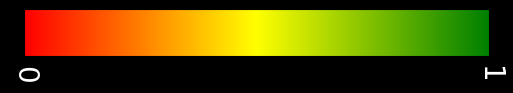

In [51]:
import matplotlib.colors


def color_legend():
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "", ["red", "yellow", "green"])
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))

    fig, ax = plt.subplots(1, figsize=(6, 2), facecolor='black')
    plt.tick_params(axis='x', labelcolor=[1, 1, 1])
    plt.tick_params(axis='x', labelsize=20)
    ax.get_yaxis().set_visible(False)
    ax.imshow([colors], extent=[0, 10, 0, 1])
    ax.set(xticks=([0, 10]))
    ax.set(xticklabels=([0, 1]))
    ax.tick_params(axis='x', labelrotation=-90)
    plt.savefig('/content/drive/MyDrive/Resources/color_legend.png'.format(slash),
                facecolor=fig.get_facecolor())
    return fig


cl = color_legend()

In [52]:
def add_cl(image, y, x, width_ratio, height_ratio, dist, sim_diff_function):

    cl = cv2.imread('/content/drive/MyDrive/Resources/color_legend.png')
    dim = (int(image.shape[0]*height_ratio), int(image.shape[1]*width_ratio))
    cl = cv2.resize(cl, dim)
    cl_img = cv2.rotate(cl, cv2.ROTATE_90_COUNTERCLOCKWISE)
    cl_height, cl_width, _ = cl_img.shape

    dist_in = dist
    if 'similarity' in sim_diff_function.__name__.lower():
        dist_inv = 1 - dist

    dist_y = dist_inv*cl_height

    start_point = (int(0.7*cl_width), int(0.1*cl_height))
    end_point = (int(cl_width-(0.7*cl_width)), int(int(0.1*cl_height)+dist_y))
    cv2.rectangle(cl_img, start_point, end_point, (0, 0, 0), -1)

    gray_cl = cv2.cvtColor(cl_img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray_cl, 0, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    roi = image[y:y+cl_height, x:x+cl_width]
    img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
    result = cv2.add(img_bg, cl_img)
    image[y:y+cl_height, x:x+cl_width] = result

    alpha = 0.5
    beta = (1.0 - alpha)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    dst = cv2.addWeighted(
        image[y:y+cl_height, x:x+cl_width], alpha, mask, beta, 0.0)

    image[y:y+cl_height, x:x+cl_width] = dst

    ps.putBText(image, "Similarity score",
                text_offset_x=5, text_offset_y=y-25, vspace=5, hspace=5,
                font_scale=1, background_RGB=(0, 0, 0), text_RGB=(255, 250, 250))
    ps.putBText(image, f'{dist*100:.2f}%',
                text_offset_x=5, text_offset_y=y+cl_height+5, vspace=5, hspace=5,
                font_scale=1, background_RGB=(0, 0, 0), text_RGB=(255, 250, 250))

## Progress bar

In [53]:
def progressBar(image: np.array, dist: float, cost: float, sim_diff_function):
    """
    วาดหลอดแสดงค่าคะแนน แสดงเป็นค่าความเหมือน

    input:
        image : frame ภาพที่จะวาด
        dist : ค่าคะแนนความต่าง/ความเหมือนต่อเฟรม
        cost : ยอดสะสมค่าคะแนนความต่าง/ความเหมือน
        sim_diff_function : ฟังก์ชันที่ใช้ในการคำนวณความต่าง/ความเหมือน

    output:
        หลอดแนวตั้ง: แสดงค่าความเหมือนของวิดิโอทั้ง 2 ในคู่เฟรมนั้นๆ
        หลอดแนวนอน: แสดงค่าความเหมือนรวมกันตั้งแต่ต้นยันจบของ 2 วิดิโอ
    """
    height, width, _ = image.shape

    if 'difference' in sim_diff_function.__name__.lower():
        dist = 1 - dist
        cost = 1 - cost

    cv2.line(image, (0, height), (width, height), (255, 255, 255), 40)
    cv2.line(image, (0, height), (int(cost*width), height), (50, 205, 50), 40)
    cv2.putText(image, 'Total Similarity Score: ', (0, height), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(image, '{:.2f}'.format(cost*100), (int(cost*width)-35, height), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 0), 2, cv2.LINE_AA)

## Error point

In [54]:
def form_vec(coor_arr: np.array):
    """
    เอาเฉพาะ x กับ y ในตำแหน่งข้อต่อ

    input:
        coor_arr: ตำแหน่งข้อต่อ 3 มิติ (x,y,z)

    output:
        ตำแหน่งข้อต่อ 2 มิติ
    """
    return (int(coor_arr[0]), int(coor_arr[1]))

In [55]:
def denormalize_landmark(cam_landmark: np.array, mapped_landmark: list, width: int, height: int):
    """
    denormalize landmark

    input:
        cam_landmark : ตำแหน่งข้อต่อแบบ camera coordinate
        mapped_landmark : ตำแหน่ง landmark ที่ k ใน cam_landmark
        width : ความกว้างของรูป (x)
        height : ความสูงของรูป (y)

    output:
        denorm_landmark : denormalized landmark
    """

    denorm_landmark = []
    for i in mapped_landmark:
        denorm_landmark.append(
            [cam_landmark[i][0]*width, cam_landmark[i][1]*height, cam_landmark[i][2]*width])
    denorm_landmark.append(
        [cam_landmark[19][0]*width, cam_landmark[19][1]*height, cam_landmark[19][2]*width])
    denorm_landmark.append(
        [cam_landmark[20][0]*width, cam_landmark[20][1]*height, cam_landmark[20][2]*width])
    denorm_landmark.append(
        [cam_landmark[31][0]*width, cam_landmark[31][1]*height, cam_landmark[31][2]*width])
    denorm_landmark.append(
        [cam_landmark[32][0]*width, cam_landmark[32][1]*height, cam_landmark[32][2]*width])

    return denorm_landmark

In [56]:
def map_landmark(sim_diff_function, k: int):
    """
    ฟังก์ชัน map ตำแหน่งของข้อพับทั้ง 12 หรือท่อนแขนท่อนขาทั้ง 16 เป็นตำแหน่งใน cam_landmark

    input:
        sim_diff_function : ฟังก์ชันที่ใช้ในการคำนวณค่าคะแนน
        k : ข้อพับ/ท่อนแขนท่อนขาที่เท่าไหร่

    output:
        dict_map[k] : ตำแหน่งของข้อพับ/ท่อนแขนท่อนขาที่ k ใน cam_landmark
    """

    if "angle" in sim_diff_function.__name__.lower():
        dict_map = {0: [16], 1: [14], 2: [12], 3: [24], 4: [26], 5: [
            28], 6: [15], 7: [13], 8: [11], 9: [23], 10: [25], 11: [27]}
    elif "cosine" in sim_diff_function.__name__.lower():
        dict_map = {0: [28, 32], 1: [26, 28], 2: [24, 26], 3: [12, 24], 4: [16, 20], 5: [14, 16], 6: [12, 14], 7: [27, 31], 8: [25, 27], 9: [23, 25],
                    10: [11, 23], 11: [15, 19], 12: [13, 15], 13: [11, 13], 14: [11, 12], 15: [23, 24]}
    return dict_map[k]

In [57]:
def color_error(cam_landmark: np.array, width: int, height: int, image: np.array, dist_lndmk_mat: np.array, k: int,
                weight: np.array, sim_diff_function):
    """
    ฟังก์ชันแสดงจุดที่ผิดพลาด

    input:
        cam_landmark : ตำแหน่งข้อต่อแบบ camera coordinate
        width : ความกว้างของรูป (x)
        height : ความสูงของรูป (y)
        image : รูปภาพ frame ที่ต้องการ
        dist_lndmk_mat : ค่าคะนนความต่าง/ความเหมือน ของแต่ละข้อต่อ ของทุกคู่เฟรม (แยกข้อต่อ/แยกท่อนแขนท่อนขา)
        k : ข้อต่อ/ท่อนแขนท่อนขา ที่เท่าไหร่ใน dist_lndmk_mat
        weight : ค่าถ่วงน้ำหนักที่ได้จาก csv config
        sim_diff_function : ฟังก์ชันที่ใช้คำนวณความต่าง/ความเหมือน

    output:
        new_image : ภาพที่แสดงจุดผิดพลาดไป 1 ข้อต่อ/ท่อนแขนท่อนขา
    """

    annotated_img = image.copy()
    denorm_landmark = denormalize_landmark(
        cam_landmark, map_landmark(sim_diff_function, k), width, height)

    for i in range(len(denorm_landmark)):
        cv2.circle(image, (int(denorm_landmark[i][0]), int(
            denorm_landmark[i][1])), 4, (255, 255, 255), -1)

    ori_similarity = dist_lndmk_mat[k]

    if "angle" in sim_diff_function.__name__.lower():
        bright = ori_similarity*255
        size = int(max(5, min(20, 1/(ori_similarity))))

        cv2.circle(annotated_img, (int(denorm_landmark[0][0]), int(
            denorm_landmark[0][1])), size, (0, bright, 255), -1)

    elif "cosine" in sim_diff_function.__name__.lower():
        bright = ori_similarity*255
        size = int(max(3, min(20, 1/(ori_similarity))))

        cv2.line(annotated_img, form_vec(denorm_landmark[0]), form_vec(
            denorm_landmark[1]), (0, bright, 255), size)

    opacity = 0.4
    new_image = cv2.addWeighted(annotated_img, opacity, image, 1 - opacity, 0)

    return new_image

## Graph

In [58]:
import wget
import matplotlib.font_manager as mpl

path = './thsarabunnew-webfont.ttf'

check_file = os.path.isfile(path)

if not check_file:

    URL = "https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf"
    wget.download(URL, "thsarabunnew-webfont.ttf")

mpl.fontManager.addfont("thsarabunnew-webfont.ttf")

In [59]:
def plot_dtw(path: list, cost_mat: np.array, name_vid1: str, name_vid2: str, sim_diff_function, destination_path: str):
    """
    plot กราฟเส้นทางที่ดีที่สุด (path) ของ DTW

    input:
        path : เส้นทางที่ดีที่สุดของ DTW ได้จากฟังก์ชัน dtw
        cost_mat : cost matrix ผลรวมของคะแนนความต่าง/ความเหมือน ของทุกคู่เฟรมในเส้นทาง ได้จากฟังก์ชัน dtw
        name_vid1 : ชื่อวิดิโอที่ 1
        name_vid2 : ชื่อวิดิโอที่ 2
        sim_diff_function : ฟังก์ชันที่ใช้คำนวณความต่าง/ความเหมือน ex. cosine_similarity, angle_difference

    output:
        path.png : กราฟแสดงเส้นทางของ DTW
    """

    print("{}-{} ({})".format(name_vid1, name_vid2, sim_diff_function.__name__))
    fig = plt.figure()
    plt.title("Path {}_{}_{}".format(
        name_vid1, name_vid2, sim_diff_function.__name__))
    plt.axis([-10, cost_mat.shape[1], -10, cost_mat.shape[0]])
    plt.grid(False)
    ax = plt.gca()
    ax.set_ylim(cost_mat.shape[0], -10)
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()
    ax.set_xlabel(name_vid2)
    ax.set_ylabel(name_vid1)

    x_path, y_path = zip(*path)
    ax.plot(y_path, x_path)
    plt.close()
    fig.savefig("{}{}dtw_{}_{}_{}{}path.png".format(destination_path,
                slash, name_vid1, name_vid2, sim_diff_function.__name__, slash))

In [60]:
def graph_dist_path(dist_mat: np.array, path: list, name_vid1: str, name_vid2: str, sim_diff_function, destination_path: str):
    """
    plot line chart แสดงค่าคะแนนความต่าง/ความเหมือน ต่อ คู่เฟรมใน path

    input:
        dist_mat : distance matrix เมทริกซ์แสดงคะแนนความต่าง/ความเหมือน ของทุกคู่เฟรม (รวมทุกข้อต่อ/ท่อนแขนท่อนขา)
        path : เส้นทางที่ดีที่สุดของ DTW ได้จากฟังก์ชัน dtw
        name_vid1 : ชื่อวิดิโอที่ 1
        name_vid2 : ชื่อวิดิโอที่ 2
        sim_diff_function : ฟังก์ชันที่ใช้คำนวณความต่าง/ความเหมือน ex. cosine_similarity, angle_difference

    output:
        graph.png : กราฟแกน x เป็นคู่เฟรมที่อยู่ใน path แกน y เป็นค่าคะแนนความต่าง/ความเหมือน
    """

    dist_df = pd.DataFrame({'path': [str(i) for i in path], 'norm_difference': [
                           dist_mat[i, j] for i, j in path]})
    dist_df['std'] = dist_df['norm_difference'].std()
    dist_df['lower_bound'] = dist_df.apply(
        lambda x: x['norm_difference']-x['std'], axis=1)
    dist_df['upper_bound'] = dist_df.apply(
        lambda x: x['norm_difference']+x['std'], axis=1)
    fig = plt.figure(figsize=(100, 8))
    plt.plot(dist_df['path'], dist_df['norm_difference'])
    plt.fill_between(dist_df['path'], dist_df['lower_bound'],
                     dist_df['upper_bound'], color='b', alpha=.15)
    plt.title("difference")
    plt.xlabel('Path')
    plt.ylabel('difference')
    plt.xticks(rotation=90)
    plt.close()
    fig.savefig("{}{}{}_dtw_{}_{}{}graph.png".format(destination_path,
                slash, name_vid1, name_vid2, sim_diff_function.__name__, slash))

## Export Vdo

In [61]:
def hconcat_resize(img_list: list):
    """
    ต่อภาพที่ขนาดไม่เท่ากัน

    input:
        img_list : list ของรูปภาพที่ต้องการต่อ ex. [img1,img2]

    output:
        im_list_resize : รูปภาพที่ต่อกันแล้ว
    """
    # take minimum hights
    h_min = min(img.shape[0]
                for img in img_list)

    # image resizing
    im_list_resize = [cv2.resize(img,
                                 (int(img.shape[1] * h_min / img.shape[0]),
                                  h_min), interpolation=cv2.INTER_CUBIC)
                      for img in img_list]

    # return final image
    return cv2.hconcat(im_list_resize)

In [62]:
def display_img(name_vid1: str, name_vid2: str, path: list, dist_mat: np.array, dist_lndmk_mat: np.array,
                weight: np.array, sim_diff_function, path_finder, all_frame1: list, all_frame2: list, cam_land_vid1: np.array,
                cam_land_vid2: np.array, destination_path: str):
    """
    แสดงผลและเซฟรูป/วิดิโอ

    input:
        name_vid1 : ชื่อวิดิโอที่ 1
        name_vid2 : ชื่อวิดิโอที่ 2
        path : เส้นทางที่ดีที่สุดของ DTW ได้จากฟังก์ชัน dtw
        dist_mat : distance matrix เมทริกซ์แสดงคะแนนความต่าง/ความเหมือน ของทุกคู่เฟรม (รวมทุกข้อต่อ/ท่อนแขนท่อนขา)
        dist_lndmk_mat : ค่าคะนนความต่าง/ความเหมือน ของแต่ละข้อต่อ ของทุกคู่เฟรม (แยกข้อต่อ/แยกท่อนแขนท่อนขา) (ใช้แสดงจุดผิดพลาด)
        weight : ค่าถ่วงน้ำหนักที่ได้จาก csv config
        sim_diff_function : ฟังก์ชันที่ใช้คำนวณความต่าง/ความเหมือน ex. cosine_similarity, angle_difference
        all_frame1 : รูปภาพทุกเฟรมของวิดิโอที่ 1 ที่วาดโครงกระดูกแล้ว
        all_frame2 : รูปภาพทุกเฟรมของวิดิโอที่ 2 ที่วาดโครงกระดูกแล้ว
        cam_land_vid1 : ตำแหน่งข้อต่อแบบ camera coordinate ของวิดิโอที่ 1
        cam_land_vid2 : ตำแหน่งข้อต่อแบบ camera coordinate ของวิดิโอที่ 2

    output:
        folder : dtw_ชื่อวิดิโอที่1_ชื่อวิดิโอที่2_ชื่อฟังก์ชัน sim_diff_function
    """
    if len(set(weight)) > 1:
        weight_name = '-Weight'
    else:
        weight_name = '-Unweight'
    height, width, _ = hconcat_resize([all_frame1[0], all_frame2[0]]).shape
    out = cv2.VideoWriter(f'{destination_path}.avi', cv2.VideoWriter_fourcc(*'MJPG'),30,(width,height))
    cl = cv2.imread('/content/drive/MyDrive/Resources/color_legend.png'.format(slash))
    cl_img = cv2.rotate(cl, cv2.ROTATE_90_COUNTERCLOCKWISE)
    cl_height, cl_width, _ = cl_img.shape
    cost = 0
    for i, j in path:

        img1 = all_frame1[i].copy()
        img2 = all_frame2[j].copy()
        height1, width1, _ = img1.shape
        height2, width2, _ = img2.shape
        height_ratio = cl_height/max(height1, height2)
        width_ratio = cl_width/max(width1, width2)

        add_cl(image=img2,
               y=int((height2/2)-(height2*height_ratio)/2),
               x=0,
               width_ratio=width_ratio,
               height_ratio=height_ratio,
               dist=dist_mat[i, j],
               sim_diff_function=sim_diff_function)

        cost += dist_mat[i, j]/len(path)

        progressBar(image=img2,
                    dist=dist_mat[i, j],
                    cost=cost,
                    sim_diff_function=sim_diff_function)

        for k in range(dist_lndmk_mat[i, j].shape[0]):

            # color_error ใช้ได้กับ similarity อย่างเดียว
            if "similarity" in sim_diff_function.__name__.lower():
                img1 = color_error(
                    cam_land_vid1[i], width1, height1, img1, dist_lndmk_mat[i, j], k, weight, sim_diff_function)
                img2 = color_error(
                    cam_land_vid2[j], width2, height2, img2, dist_lndmk_mat[i, j], k, weight, sim_diff_function)
            elif "difference" in sim_diff_function.__name__.lower():
                img1 = color_error(
                    cam_land_vid1[i], width1, height1, img1, 1-dist_lndmk_mat[i, j], k, weight, sim_diff_function)
                img2 = color_error(
                    cam_land_vid2[j], width2, height2, img2, 1-dist_lndmk_mat[i, j], k, weight, sim_diff_function)

        merge_img = hconcat_resize([img1, img2])
        cv2.imwrite(f'{destination_path}_{i}_{j}.jpg',merge_img)
        out.write(merge_img)

    out.release()

# Warp up

##Keyframe dict

In [67]:
!rm -rf /content/dtw
!mkdir dtw

In [63]:
diff_angle_dict = {
    "เข่าตรงหลัง_ตรง": [178],
    "เข่าน้อยหน้า1_ตรง":[221],
    "เข่าน้อยหน้า2_ตรง":[268],
    "เข่าพร้อมศอกหน้า1_ตรง":[164],
    "เข่าพร้อมศอกหน้า2_ตรง":[222],
    "เข่าพร้อมศอกหลัง_ตรง": [152],
    "เตะเฉียงหน้า_ตรง": [124],
    "เตะเฉียงหลัง_ตรง": [145],
    "เตะตรงหน้า1_ตรง":[132],
    "เตะตรงหน้า2_ตรง":[106],
    "ถีบข้างสลับฟันปลาหน้า1_ตรง":[240, 274],
    "ถีบข้างสลับฟันปลาหน้า2_ตรง":[174, 229],
    "ถีบตรงหน้า1_ตรง":[241],
    "ถีบตรงหน้า2_ตรง":[251],
    "ปิดพร้อมต่อยหลัง1_ตรง":[171,190],
    "ปิดพร้อมต่อยหลัง2_ตรง":[141,181],
    "ยอเขาพระสุเมรุหน้า1_ตรง":[204],
    "ยอเขาพระสุเมรุหน้า2_ตรง":[173],
    "ศอกกระทุ้งหน้า1_ตรง":[219,240],
    "ศอกกระทุ้งหน้า2_ตรง":[223,257],
    "ศอกเฉียงตีขึ้นตีลงหน้า1_ตรง":[116,139],
    "ศอกเฉียงตีขึ้นตีลงหน้า2_ตรง":[126,156],
    "ศอกเฉียงตีขึ้นตีลงหน้า3_ตรง":[116,139],
    "ศอกเฉียงตีขึ้นหน้า1_ตรง":[144],
    "ศอกเฉียงตีขึ้นหน้า2_ตรง":[162],
    "ศอกเฉียงตีขึ้นหน้า_ตรง": [123],
    "ศอกเฉียงตีลงหน้า1_ตรง":[92],
    "ศอกเฉียงตีลงหน้า2_ตรง":[82],
    "ศอกเฉียงตีลงหน้า3_ตรง":[43],
    "ศอกเฉียงหลัง_ตรง": [136],
    "สืบถอยพร้อมต่อยหมัดตรงหน้า1_ตรง":[412],
    "สืบถอยพร้อมต่อยหมัดตรงหน้า2_ตรง":[178],
    "หมัดกระแทกหน้า_ตรง": [140]
}

In [64]:
friends_video_dict = {
    "เข่าตรงหลัง":[144],
    "เข่าตัดหน้า":[185],
    "เข่าตัดหลัง":[214],
    "เข่าน้อยหน้า":[310],
    "เข่าน้อยหลัง": [423],
    "เข่าพร้อมศอกหน้า":[220],
    "เข่าพร้อมศอกหลัง":[171],
    "เตะเฉียงหน้า":[214],
    "เตะเฉียงหลัง":[107],
    "เตะตรงหน้า":[116],
    "ถีบข้างสลับฟันปลาหน้า":[195, 232],
    "ถีบตรงหน้า":[208],
    "ปิดพร้อมต่อยหลัง":[133,171],
    "ยอเขาพระสุเมรุหน้า":[204],
    "ศอกกระทุ้งหน้า":[251,268],
    "ศอกเฉียงตีขึ้นตีลงหน้า":[84,110],
    "ศอกเฉียงตีขึ้นหน้า":[163],
    "ศอกเฉียงตีลงหน้า":[52],
    "สืบถอยพร้อมต่อยหมัดตรงหน้า":[405],
    "หมัดกระแทกหน้า":[194]
}

In [66]:
# w/ keyframe
def comparevid_kf(path_landmark1: str, path_landmark2: str, keyframes_list: list, destination_path: str, sim_diff_function, extract_function, path_finder,
                 norm_value = 180, weight = False, thresh = False, expo = False, MAW_method = 'aj', windows = 30, video = False, kf_img = False, showtext=False):

    name_vid1 = path_landmark1.split(slash)[-1]
    name_vid2 = path_landmark2.split(slash)[-1]
    name_func = sim_diff_function.__name__.split('_')[0]
    thresh_name=''
    expo_name=''
    keyframe_name=''

    if weight:
        weight_name = 'Weight'
    else:
        weight_name = 'Unweight'

    if weight == 'auto':
        weight_name = 'MAW'

    if thresh:
        thresh_name = '-thresh'

    if expo:
        expo_name = '-expo'

    if MAW_method == 'me':
        maw_met_name = '-my-method'
    else:
        maw_met_name = ''

    if len(keyframes_list) > 0:
        keyframe_name = '-keyframe'

    if weight == 'auto':
        weight = 'auto'
    elif weight:
        weight = import_weight(resource + '{}weight_config_{}_list.csv'.format(slash, name_func), name_vid1.split('_')[0])
    else:
        weight = import_weight(resource + '{}weight_config_{}_list.csv'.format(slash, name_func), "default")

    cam_land_vid1, world_land_vid1, all_frame1, = import_file(path_landmark1)
    cam_land_vid2, world_land_vid2, all_frame2 = import_file(path_landmark2)

    extracted_ladk_vid1 = extract_function(world_land_vid1)
    extracted_ladk_vid2 = extract_function(world_land_vid2)

    kf_list, stkf_list, path, dist_mat, dist_lndmk_mat, cost_mat, vert_hor, cost, stats = dtw_keyframe(name_vid1, name_vid2,
                                                                                   extracted_ladk_vid1, extracted_ladk_vid2,
                                                                                   keyframes_list, sim_diff_function,
                                                                                   path_finder, weight,
                                                                                   norm_value, windows, thresh,
                                                                                   MAW_method, expo)
    dtw_path=desktop+slash+'dtw'
    folder_name = f'dtw_{name_vid1}_{name_vid2}_{sim_diff_function.__name__}'
    file_name = f'{weight_name}{maw_met_name}{expo_name}{thresh_name}{keyframe_name}'
    if (kf_list != None) and (kf_img):
        !mkdir "{dtw_path}{slash}{folder_name}"
        !mkdir "{dtw_path}{slash}{folder_name}{slash}{file_name}"

        save_kf_img(name_vid1, name_vid2, all_frame1, all_frame2,
                    kf_list, stkf_list, '{}{}dtw_{}_{}_{}{}{}{}{}{}{}'.format(dtw_path, slash, name_vid1, name_vid2, sim_diff_function.__name__, slash,
                                                                                weight_name, maw_met_name, expo_name, thresh_name, keyframe_name))

    Non_sync_one_to_many_pair  = vert_hor - (np.abs(len(all_frame1) - len(all_frame2)))
    Non_sync_one_to_many_pair_percent = ((Non_sync_one_to_many_pair /min(len(all_frame1), len(all_frame2))) *100)/2

    if video:
        !mkdir "{dtw_path}{slash}{folder_name}"
        display_img(name_vid1, name_vid2, path, dist_mat, dist_lndmk_mat, weight,
                    sim_diff_function, path_finder, all_frame1, all_frame2, cam_land_vid1, cam_land_vid2,
                    f'{dtw_path}{slash}{folder_name}{slash}{folder_name+"-"+file_name}')

    return cost, Non_sync_one_to_many_pair_percent, stats, kf_list, stkf_list, dist_mat

# Summary report

In [70]:
def warp_sum_cosine_kf(path_vid1: str, path_vid2: str, keyframe_list: list, weight, norm_value: int,
                       windows=30, thresh=False, MAW_method='aj', expo=False, video=False, kf_img=False):

    # bottom-right to top-left
    cost_sim_dp, non_sync_diff_sim_dp, stats_sim_dp, kf, stkf, dist_mat = comparevid_kf(path_landmark1=path_vid1,
                                                                                        path_landmark2=path_vid2,
                                                                                        keyframes_list=keyframe_list,
                                                                                        destination_path=desktop+slash+'dtw',
                                                                                        sim_diff_function=cosine_similarity,
                                                                                        extract_function=find_limb,
                                                                                        path_finder=dp,
                                                                                        weight=weight,
                                                                                        norm_value=norm_value,
                                                                                        windows=windows,
                                                                                        showtext=False,
                                                                                        thresh=thresh,
                                                                                        MAW_method=MAW_method,
                                                                                        expo=expo,
                                                                                        video=video,
                                                                                        kf_img=kf_img)

    cost_list = [cost_sim_dp]
    frames_list = [stats_sim_dp[3]]
    mean_list = [stats_sim_dp[2]]
    std_uni_list = [stats_sim_dp[1]]
    std_all_list = [stats_sim_dp[0]]
    non_sync_list = [non_sync_diff_sim_dp]
    method_list = ['cosine similarity (br-tl)']
    vid_name_list = ['{}_{}'.format(path_vid1.split(
        slash)[-1], path_vid2.split(slash)[-1])]

    return cost_list, mean_list, std_all_list, std_uni_list, frames_list, non_sync_list, method_list, vid_name_list, kf, stkf, dist_mat

In [71]:
def warp_sum_angle_kf(path_vid1: str, path_vid2: str, keyframe_list: list, weight, norm_value: int,
                      windows=30, thresh=False,  MAW_method='aj', expo=False, video=False, kf_img=False):

    # bottom-right to top-left
    cost_sim_dp, non_sync_diff_sim_dp, stats_sim_dp, kf, stkf, dist_mat = comparevid_kf(path_landmark1=path_vid1,
                                                                                        path_landmark2=path_vid2,
                                                                                        keyframes_list=keyframe_list,
                                                                                        destination_path=desktop+slash+'dtw',
                                                                                        sim_diff_function=angle_similarity,
                                                                                        extract_function=find_angle,
                                                                                        path_finder=dp,
                                                                                        weight=weight,
                                                                                        norm_value=norm_value,
                                                                                        windows=windows,
                                                                                        showtext=False,
                                                                                        thresh=thresh,
                                                                                        MAW_method=MAW_method,
                                                                                        expo=expo,
                                                                                        video=video,
                                                                                        kf_img=kf_img)

    cost_list = [cost_sim_dp]
    frames_list = [stats_sim_dp[3]]
    mean_list = [stats_sim_dp[2]]
    std_uni_list = [stats_sim_dp[1]]
    std_all_list = [stats_sim_dp[0]]
    non_sync_list = [non_sync_diff_sim_dp]
    method_list = ['angle similarity (br-tl)']
    vid_name_list = ['{}_{}'.format(path_vid1.split(
        slash)[-1], path_vid2.split(slash)[-1])]

    return cost_list, mean_list, std_all_list, std_uni_list, frames_list, non_sync_list, method_list, vid_name_list, kf, stkf, dist_mat

In [72]:
def middle_kf(lis):
  if len(lis) == 2:
    lis = [lis[1]].copy()
  else:
    lis = lis[1 : len(lis) - 1].copy()

  return lis

In [73]:
def case1_kf(path: str, keyframe_dict: dict, weight, threshold: bool, exponential: bool,
             angle_cosine_func, auto_method='aj', window=30, video=True, kf_img=False):

    thresh_name = ''
    expo_name = ''
    keyframe_name = ''

    if weight:
        weight_name = '-Weight'
    else:
        weight_name = '-Unweight'

    if weight == 'auto':
        weight_name = '-MAW'
    else:
        window = ''

    if threshold:
        thresh_name = '-thresh'

    if exponential:
        expo_name = '-expo'

    if auto_method == 'me':
        maw_met_name = '-my-method'
    else:
        maw_met_name = ''

    if keyframe_dict != []:
        keyframe_name = '-keyframe'

    func_name = angle_cosine_func.__name__.split('_')[2]

    norm_val_list = [180,90,45]
    all_cost_list = []
    all_mean_list = []
    all_std_all_list = []
    all_std_uni_list = []
    all_frames_list = []
    all_non_sync_list = []
    all_method_list = []
    all_vid_name_list = []
    all_norm_list = []
    all_case_list = []
    all_kf_list = []
    all_stkf_list = []
    all_kf_score_list = []
    all_kf_mean_list = []


    for norm in norm_val_list:
        for i,j in zip(sorted(glob(path+'{}landmarks{}**{}**_ตรง'.format(slash, slash, slash))),sorted(glob(path+'{}landmarks{}**{}**_เฉียง'.format(slash, slash, slash)))):

            vid1_name = i.split(slash)[-1]
            vid2_name = j.split(slash)[-1]

            if keyframe_dict == []:
                kf = []
            else:
                kf = copy(keyframe_dict[vid1_name])
            cost_list, mean_list, std_all_list, std_uni_list, frames_list, non_sync_list, method_list, vid_name_list, kf, stkf, dist_mat = angle_cosine_func(path_vid1=i,
                                                                                                                                         path_vid2=j,
                                                                                                                                         keyframe_list=kf,
                                                                                                                                         weight=weight,
                                                                                                                                         norm_value=norm,
                                                                                                                                         thresh=threshold,
                                                                                                                                         windows=window,
                                                                                                                                         expo=exponential,
                                                                                                                                         MAW_method=auto_method,
                                                                                                                                         video=video,
                                                                                                                                         kf_img=kf_img)

            all_cost_list.extend(cost_list)
            all_mean_list.extend(mean_list)
            all_std_all_list.extend(std_all_list)
            all_std_uni_list.extend(std_uni_list)
            all_frames_list.extend(frames_list)
            all_non_sync_list.extend(non_sync_list)
            all_method_list.extend(method_list)
            all_vid_name_list.extend(vid_name_list)
            all_norm_list.extend([norm])
            all_case_list.extend(['case1'])
            if keyframe_dict != []:
                print(kf)
                print(stkf)
                trim_kf = middle_kf(kf)
                trim_stkf = middle_kf(stkf)
                all_kf_list.append(trim_kf)
                all_stkf_list.append(trim_stkf)
                all_kf_score_list.append(dist_mat[np.array(trim_kf), np.array(trim_stkf)])
                all_kf_mean_list.append(np.mean(dist_mat[np.array(trim_kf), np.array(trim_stkf)]))
                df_case1 = pd.DataFrame({'Video_name': all_vid_name_list,
                                        'Similarity_score': all_cost_list,
                                        'Mean': all_mean_list,
                                        'Std_all.': all_std_all_list,
                                        'Std_unique': all_std_uni_list,
                                        'All_frames_list': all_frames_list,
                                        'Non_sync_percent': all_non_sync_list,
                                        'Method': all_method_list,
                                        'Normalize_value': all_norm_list,
                                        'Case': all_case_list,
                                        'Teacher_keyframes': all_kf_list,
                                        'Student_keyframes': all_stkf_list,
                                        'Keyframe_scores': all_kf_score_list,
                                        'Keyframe_mean_score': all_kf_mean_list})
            else:
                df_case1 = pd.DataFrame({'Video_name': all_vid_name_list,
                                        'Similarity_score': all_cost_list,
                                        'Mean': all_mean_list,
                                        'Std_all.': all_std_all_list,
                                        'Std_unique': all_std_uni_list,
                                        'All_frames_list': all_frames_list,
                                        'Non_sync_percent': all_non_sync_list,
                                        'Method': all_method_list,
                                        'Normalize_value': all_norm_list,
                                        'Case': all_case_list})


    weight_name = weight_name.replace('-','')
    file_name = '{}{}{}{}{}{}_{}_case1'.format(weight_name, window, maw_met_name, expo_name,
                                                   thresh_name, keyframe_name, func_name)

    if len(glob(desktop + slash + file_name + '*.csv')) != 0:
        num = len(glob(desktop + slash + file_name + '*'))
        df_case1.to_csv(desktop + slash + file_name + '({})'.format(num) + '.csv')
    else:
        df_case1.to_csv(desktop + slash + file_name + '.csv')

In [74]:
def case2_kf(path: str, keyframe_dict: dict, weight, threshold: bool, exponential: bool,
               angle_cosine_func, auto_method='aj', window=30, video=True, kf_img=False):

    thresh_name = ''
    expo_name = ''
    keyframe_name = ''

    if weight:
        weight_name = '-Weight'
    else:
        weight_name = '-Unweight'

    if weight == 'auto':
        weight_name = '-MAW'
    else:
        window = ''

    if threshold:
        thresh_name = '-thresh'

    if exponential:
        expo_name = '-expo'

    if auto_method == 'me':
        maw_met_name = '-my-method'
    else:
        maw_met_name = ''

    if keyframe_dict != []:
        keyframe_name = '-keyframe'

    func_name = angle_cosine_func.__name__.split('_')[2]

    norm_val_list = [180,90,45]
    all_cost_list = []
    all_mean_list = []
    all_std_all_list = []
    all_std_uni_list = []
    all_frames_list = []
    all_non_sync_list = []
    all_method_list = []
    all_vid_name_list = []
    all_norm_list = []
    all_case_list = []
    all_kf_list = []
    all_stkf_list = []
    all_kf_score_list = []
    all_kf_mean_list = []


    all_vid1 = glob(path + '{}landmarks{}**{}**[!0-9]'.format(slash, slash, slash))

    for norm in norm_val_list:
        for i in all_vid1:

            vid1_name = i.split(slash)[-1]

            all_vid2 = sorted(glob(path + '{}landmarks{}**{}*{}*[0-9]'.format(slash, slash, vid1_name, slash)))
            for j in all_vid2:
                vid2_name = j.split(slash)[-1]

                print(vid1_name)
                print(vid2_name)
                print('-----------')
                print(i)
                print(j)
                print('-----------')

                if keyframe_dict == []:
                    kf = []
                else:
                    kf = keyframe_dict[vid1_name]

                cost_list, mean_list, std_all_list, std_uni_list, frames_list, non_sync_list, method_list, vid_name_list, kf, stkf, dist_mat = angle_cosine_func(path_vid1=i,
                                                                                                                                             path_vid2=j,
                                                                                                                                             keyframe_list=kf,
                                                                                                                                             weight=weight,
                                                                                                                                             norm_value=norm,
                                                                                                                                             windows=window,
                                                                                                                                             thresh=threshold,
                                                                                                                                             expo=exponential,
                                                                                                                                             MAW_method=auto_method,
                                                                                                                                             video=video,
                                                                                                                                             kf_img=kf_img)
                all_cost_list.extend(cost_list)
                all_mean_list.extend(mean_list)
                all_std_all_list.extend(std_all_list)
                all_std_uni_list.extend(std_uni_list)
                all_frames_list.extend(frames_list)
                all_non_sync_list.extend(non_sync_list)
                all_method_list.extend(method_list)
                all_vid_name_list.extend(vid_name_list)
                all_norm_list.extend([norm])
                all_case_list.extend(['case2'])
                if keyframe_dict != []:
                    print(kf)
                    print(stkf)
                    trim_kf = middle_kf(kf)
                    trim_stkf = middle_kf(stkf)
                    all_kf_list.append(trim_kf)
                    all_stkf_list.append(trim_stkf)
                    all_kf_score_list.append(dist_mat[np.array(trim_kf), np.array(trim_stkf)])
                    all_kf_mean_list.append(np.mean(dist_mat[np.array(trim_kf), np.array(trim_stkf)]))
                    df_case2 = pd.DataFrame({'Video_name': all_vid_name_list,
                                            'Similarity_score': all_cost_list,
                                            'Mean': all_mean_list,
                                            'Std_all.': all_std_all_list,
                                            'Std_unique': all_std_uni_list,
                                            'All_frames_list': all_frames_list,
                                            'Non_sync_percent': all_non_sync_list,
                                            'Method': all_method_list,
                                            'Normalize_value': all_norm_list,
                                            'Case': all_case_list,
                                                'Teacher_keyframes': all_kf_list,
                                                'Student_keyframes': all_stkf_list,
                                                'Keyframe_scores': all_kf_score_list,
                                                'Keyframe_mean_score': all_kf_mean_list})
                else:
                    df_case2 = pd.DataFrame({'Video_name': all_vid_name_list,
                                            'Similarity_score': all_cost_list,
                                            'Mean': all_mean_list,
                                            'Std_all.': all_std_all_list,
                                            'Std_unique': all_std_uni_list,
                                            'All_frames_list': all_frames_list,
                                            'Non_sync_percent': all_non_sync_list,
                                            'Method': all_method_list,
                                            'Normalize_value': all_norm_list,
                                            'Case': all_case_list})



    weight_name = weight_name.replace('-','')
    file_name = '{}{}{}{}{}{}_{}_case2'.format(weight_name, window, maw_met_name, expo_name,
                                                     thresh_name, keyframe_name, func_name)

    if len(glob(desktop + slash + file_name + '*.csv')) != 0:
        num = len(glob(desktop + slash + file_name + '*'))
        df_case2.to_csv(desktop + slash + file_name + '({})'.format(num) + '.csv')
    else:
        df_case2.to_csv(desktop + slash + file_name + '.csv')

In [75]:
def case3_kf(path: str, keyframe_dict: dict, weight, threshold: bool, exponential: bool,
               angle_cosine_func, auto_method='aj', window=30, video=True, kf_img=False):

    thresh_name = ''
    expo_name = ''
    keyframe_name = ''

    if weight:
        weight_name = '-Weight'
    else:
        weight_name = '-Unweight'

    if weight == 'auto':
        weight_name = '-MAW'
    else:
        window = ''

    if threshold:
        thresh_name = '-thresh'

    if exponential:
        expo_name = '-expo'

    if auto_method == 'me':
        maw_met_name = '-my-method'
    else:
        maw_met_name = ''

    if keyframe_dict != []:
        keyframe_name = '-keyframe'

    func_name = angle_cosine_func.__name__.split('_')[2]

    norm_val_list = [180,90,45] # เฉพาะ 45 องศา
    all_cost_list = []
    all_mean_list = []
    all_std_all_list = []
    all_std_uni_list = []
    all_frames_list = []
    all_non_sync_list = []
    all_method_list = []
    all_vid_name_list = []
    all_norm_list = []
    all_case_list = []
    all_kf_list = []
    all_stkf_list = []
    all_kf_score_list = []
    all_kf_mean_list = []

    all_vid1 = glob(path + '{}landmarks{}**{}**[!0-9]'.format(slash, slash, slash))

    for norm in norm_val_list:
        for i in all_vid1:

            vid1_name = i.split(slash)[-1]

            all_vid2 = sorted(glob(path + '{}landmarks{}**[!{}]*{}*[0-9]'.format(slash, slash, vid1_name, slash)))
            for j in all_vid2:
                vid2_name = j.split(slash)[-1]

                print(vid1_name)
                print(vid2_name)
                print('-----------')
                print(i)
                print(j)
                print('-----------')

                if keyframe_dict == []:
                    kf = []
                else:
                    kf = keyframe_dict[vid1_name]

                cost_list, mean_list, std_all_list, std_uni_list, frames_list, non_sync_list, method_list, vid_name_list, kf ,stkf, dist_mat = angle_cosine_func(path_vid1=i,
                                                                                                                                             path_vid2=j,
                                                                                                                                             keyframe_list=kf,
                                                                                                                                             weight=weight,
                                                                                                                                             norm_value=norm,
                                                                                                                                             windows=window,
                                                                                                                                             thresh=threshold,
                                                                                                                                             expo=exponential,
                                                                                                                                             MAW_method=auto_method,
                                                                                                                                             video=video,
                                                                                                                                             kf_img=kf_img)
                all_cost_list.extend(cost_list)
                all_mean_list.extend(mean_list)
                all_std_all_list.extend(std_all_list)
                all_std_uni_list.extend(std_uni_list)
                all_frames_list.extend(frames_list)
                all_non_sync_list.extend(non_sync_list)
                all_method_list.extend(method_list)
                all_vid_name_list.extend(vid_name_list)
                all_norm_list.extend([norm])
                all_case_list.extend(['case3'])
                if keyframe_dict != []:
                    trim_kf = middle_kf(kf)
                    trim_stkf = middle_kf(stkf)
                    all_kf_list.append(trim_kf)
                    all_stkf_list.append(trim_stkf)
                    all_kf_score_list.append(dist_mat[np.array(trim_kf), np.array(trim_stkf)])
                    all_kf_mean_list.append(np.mean(dist_mat[np.array(trim_kf), np.array(trim_stkf)]))
                    df_case3 = pd.DataFrame({'Video_name': all_vid_name_list,
                                                'Similarity_score': all_cost_list,
                                                'Mean': all_mean_list,
                                                'Std_all.': all_std_all_list,
                                                'Std_unique': all_std_uni_list,
                                                'All_frames_list': all_frames_list,
                                                'Non_sync_percent': all_non_sync_list,
                                                'Method': all_method_list,
                                                'Normalize_value': all_norm_list,
                                                'Case': all_case_list,
                                                'Teacher_keyframes': all_kf_list,
                                                'Student_keyframes': all_stkf_list,
                                                'Keyframe_scores': all_kf_score_list,
                                                'Keyframe_mean_score': all_kf_mean_list})
                else:
                    df_case3 = pd.DataFrame({'Video_name': all_vid_name_list,
                                                'Similarity_score': all_cost_list,
                                                'Mean': all_mean_list,
                                                'Std_all.': all_std_all_list,
                                                'Std_unique': all_std_uni_list,
                                                'All_frames_list': all_frames_list,
                                                'Non_sync_percent': all_non_sync_list,
                                                'Method': all_method_list,
                                                'Normalize_value': all_norm_list,
                                                'Case': all_case_list})



    weight_name = weight_name.replace('-','')
    file_name = '{}{}{}{}{}{}_{}_case3'.format(weight_name, window, maw_met_name, expo_name,
                                                     thresh_name, keyframe_name, func_name)

    if len(glob(desktop + slash + file_name + '*.csv')) != 0:
        num = len(glob(desktop + slash + file_name + '*'))
        df_case3.to_csv(desktop + slash + file_name + '({})'.format(num) + '.csv')
    else:
        df_case3.to_csv(desktop + slash + file_name + '.csv')

# Run

In [76]:
thresh_var = False
expo_var = True

## Unweight cosine

### Case1

In [77]:
!mkdir lastest_result

In [78]:
%%capture
case1_kf(path = diff_angle,
         keyframe_dict = [], #diff_angle_dict
         weight = False,
         threshold = thresh_var,
         exponential = expo_var,
         angle_cosine_func = warp_sum_cosine_kf,
         kf_img = False,
         video = False)

In [79]:
!mv '/content/Unweight-expo_cosine_case1.csv' '/content/lastest_result'

### case 2

In [80]:
%%capture
case2_kf(path = friends_video,
           keyframe_dict = [], #friends_video_dict
           weight = False,
           threshold = thresh_var,
           exponential = expo_var,
           angle_cosine_func = warp_sum_cosine_kf,
           kf_img = False,
           video = False)

In [81]:
!mv '/content/Unweight-expo_cosine_case2.csv' '/content/lastest_result'

### Case 3

In [ ]:
%%capture
case3_kf(path = friends_video,
           keyframe_dict = [],
           weight = False,
           threshold = thresh_var,
           exponential = expo_var,
           angle_cosine_func = warp_sum_cosine_kf,
           kf_img = False,
           video = False)

In [ ]:
!mv '/content/Unweight-expo_cosine_case3.csv' '/content/lastest_result'

## Unweight angle

### case 1

In [ ]:
%%capture
case1_kf(path = diff_angle,
         keyframe_dict = [],
         weight = False,
         threshold = thresh_var,
         exponential = expo_var,
         angle_cosine_func = warp_sum_angle_kf,
         kf_img = False,
         video = False)

In [ ]:
!mv '/content/Unweight-expo_angle_case1.csv' '/content/lastest_result'

### case 2

In [ ]:
%%capture
case2_kf(path = friends_video,
           keyframe_dict = [],
           weight = False,
           threshold = thresh_var,
           exponential = expo_var,
           angle_cosine_func = warp_sum_angle_kf,
           kf_img = False,
           video = False)

In [ ]:
!mv '/content/Unweight-expo_angle_case2.csv' '/content/lastest_result'

### case 3

In [ ]:
%%capture
case3_kf(path = friends_video,
           keyframe_dict = [],
           weight = False,
           threshold = thresh_var,
           exponential = expo_var,
           angle_cosine_func = warp_sum_angle_kf,
           kf_img = False,
           video = False)

In [ ]:
!mv '/content/Unweight-expo_angle_case3.csv' '/content/lastest_result'

## Weight cosine

### case 1

In [ ]:
%%capture
case1_kf(path = diff_angle,
         keyframe_dict = [],
         weight = True,
         threshold = False,
         exponential = True,
         angle_cosine_func = warp_sum_cosine_kf,
         kf_img = False,
         video = False)

In [ ]:
!mv '/content/Weight-expo_cosine_case1.csv' '/content/lastest_result'

### case 2


In [ ]:
%%capture
case2_kf(path = friends_video,
           keyframe_dict = [],
           weight = True,
           threshold = False,
           exponential = False,
           angle_cosine_func = warp_sum_cosine_kf,
           kf_img = False,
           video = False)

In [ ]:
!mv '/content/Weight_cosine_case2.csv' '/content/lastest_result'

### case 3

In [ ]:
%%capture
case3_kf(path = friends_video,
           keyframe_dict = [],
           weight = True,
           threshold = False,
           exponential = False,
           angle_cosine_func = warp_sum_cosine_kf,
           kf_img = False,
           video = False)

In [ ]:
!mv '/content/Weight_cosine_case3.csv' '/content/lastest_result'

## Weight angle

### case 1

In [ ]:
%%capture
case1_kf(path = diff_angle,
         keyframe_dict = [],
         weight = True,
         threshold = False,
         exponential = True,
         angle_cosine_func = warp_sum_angle_kf,
         kf_img = False,
         video = False)

In [ ]:
!mv '/content/Weight-expo_angle_case1.csv' '/content/lastest_result'

### case 2

In [ ]:
%%capture
case2_kf(path = friends_video,
           keyframe_dict = [],
           weight = True,
           threshold = False,
           exponential = False,
           angle_cosine_func = warp_sum_angle_kf,
           kf_img = False,
           video = False)

In [ ]:
!mv '/content/Weight_angle_case2.csv' '/content/lastest_result'

### case 3

In [ ]:
%%capture
case3_kf(path = friends_video,
           keyframe_dict = [],
           weight = True,
           threshold = False,
           exponential = False,
           angle_cosine_func = warp_sum_angle_kf,
           kf_img = False,
           video = False)

In [ ]:
!mv '/content/Weight_angle_case3.csv' '/content/lastest_result'

## Moving weight cosine

### case1

In [ ]:
%%capture
for w in [30,60,90]:
    case1_kf(path = diff_angle,
            keyframe_dict = diff_angle_dict,
            weight = 'auto',
            threshold = False,
            exponential = False,
            angle_cosine_func = warp_sum_cosine_kf,
            auto_method='aj',
            window=w,
            kf_img = False,
            video = False)

In [ ]:
!mv '/content/MAW30-keyframe_cosine_case1.csv' '/content/lastest_result'
!mv '/content/MAW60-keyframe_cosine_case1.csv' '/content/lastest_result'
!mv '/content/MAW90-keyframe_cosine_case1.csv' '/content/lastest_result'

### case 2

In [ ]:
%%capture
for w in [30,60,90]:
    case2_kf(path = friends_video,
            keyframe_dict = [],
            weight = False,
            threshold = False,
            exponential = False,
            angle_cosine_func = warp_sum_cosine_kf,
            auto_method='aj',
            window=w,
            kf_img = False,
            video = False)

In [ ]:
!mv '/content/MAW30_cosine_case2.csv' '/content/lastest_result'
!mv '/content/MAW60_cosine_case2.csv' '/content/lastest_result'
!mv '/content/MAW90_cosine_case2.csv' '/content/lastest_result'

### case 3

In [ ]:
%%capture
for w in [30,60,90]:
    case3_kf(path = friends_video,
            keyframe_dict = [],
            weight = 'auto',
            threshold = False,
            exponential = False,
            angle_cosine_func = warp_sum_cosine_kf,
            auto_method='aj',
            window=w,
            kf_img = False,
            video = False)

In [ ]:
!mv '/content/MAW30_cosine_case3.csv' '/content/lastest_result'
!mv '/content/MAW60_cosine_case3.csv' '/content/lastest_result'
!mv '/content/MAW90_cosine_case3.csv' '/content/lastest_result'

## Moving weight angle

### case 1

In [ ]:
%%capture
for w in [30,60,90]:
    case1_kf(path = diff_angle,
            keyframe_dict = diff_angle_dict,
            weight = 'auto',
            threshold = False,
            exponential = False,
            angle_cosine_func = warp_sum_angle_kf,
            auto_method='aj',
            window=w,
            kf_img = False,
            video = False)

In [ ]:
!mv '/content/MAW30-keyframe_angle_case1.csv' '/content/lastest_result'
!mv '/content/MAW60-keyframe_angle_case1.csv' '/content/lastest_result'
!mv '/content/MAW90-keyframe_angle_case1.csv' '/content/lastest_result'

### case 2

In [ ]:
%%capture
for w in [30,60,90]:
    case2_kf(path = friends_video,
            keyframe_dict = [],
            weight = False,
            threshold = False,
            exponential = False,
            angle_cosine_func = warp_sum_angle_kf,
            auto_method='aj',
            window=w,
            kf_img = False,
            video = False)

In [ ]:
!mv '/content/MAW30_angle_case2.csv' '/content/lastest_result'
!mv '/content/MAW60_angle_case2.csv' '/content/lastest_result'
!mv '/content/MAW90_angle_case2.csv' '/content/lastest_result'

### case 3

In [ ]:
%%capture
for w in [30,60,90]:
    case3_kf(path = friends_video,
            keyframe_dict = [],
            weight = 'auto',
            threshold = False,
            exponential = False,
            angle_cosine_func = warp_sum_angle_kf,
            auto_method='aj',
            window=w,
            kf_img = False,
            video = False)

In [ ]:
!mv '/content/MAW30_angle_case3.csv' '/content/lastest_result'
!mv '/content/MAW60_angle_case3.csv' '/content/lastest_result'
!mv '/content/MAW90_angle_case3.csv' '/content/lastest_result'